<a href="https://colab.research.google.com/github/kmouleejunhyuk/titanic_review/blob/main/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
##캐글의 타이타닉 분석 리뷰
#리더보드 정확도 100% 전처리 기법 사용


#원본: https://www.kaggle.com/imoore/titanic-the-only-notebook-you-need-to-see
#추가로, 다층 FCNN 모델+kfold 구현 연습

In [2]:
#환경

#google colab, pytorch

In [3]:
 
#구글 드라이브 마운트 & 경로설정
#마운트하기 전, 구글 드라이브의 titanic 폴더에 타이타닉 csv를 업로드해야 합니다
#kaggle 가입 후 데이터를 받을 수 있습니다
 
from google.colab import drive
drive.mount('/gdrive')
 
 
PATH='/gdrive/My Drive/titanic'

Mounted at /gdrive


라이브러리 로드

In [44]:
import pandas as pd
import numpy as np
import re
import os

import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import torch

데이터 로드

In [45]:
train = pd.read_csv(os.path.join(PATH, 'train.csv'))
test = pd.read_csv(os.path.join(PATH, 'test.csv'))

passengerid=test['PassengerId'].ravel()

In [46]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [47]:
print(train.head())
print(test.head())

print(train.columns)

   PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
0            1         0       3  ...   7.2500   NaN         S
1            2         1       1  ...  71.2833   C85         C
2            3         1       3  ...   7.9250   NaN         S
3            4         1       1  ...  53.1000  C123         S
4            5         0       3  ...   8.0500   NaN         S

[5 rows x 12 columns]
   PassengerId  Pclass  ... Cabin Embarked
0          892       3  ...   NaN        Q
1          893       3  ...   NaN        S
2          894       2  ...   NaN        Q
3          895       3  ...   NaN        S
4          896       3  ...   NaN        S

[5 rows x 11 columns]
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


데이터에 ticket_type라는 변수 추가(이유는 잘 모르겠다)


In [48]:
#원본에서는 pd.DataFrame.apply()를 사용했지만, 속도 개선을 위해 np.vectorize() 사용
train['Ticket_type']=np.vectorize(lambda x: x[0:3])(train['Ticket'])
train['Ticket_type']=train['Ticket_type'].astype('category')
train['Ticket_type']=train['Ticket_type'].cat.codes

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_type
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,124
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,137
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,148


In [49]:
test['Ticket_type']=np.vectorize(lambda x: x[0:3])(test['Ticket'])
test['Ticket_type']=test['Ticket_type'].astype('category')
test['Ticket_type']=test['Ticket_type'].cat.codes

test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_type
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,58
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,71
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,32


데이터에 이름 길이에 관한 변수 추가

In [50]:
train['Word_count']=np.vectorize(lambda x: len(x.split()))(train['Name'])
test['Word_count']=np.vectorize(lambda x: len(x.split()))(test['Name'])

Cabin 호수 별 변수 추가

In [51]:
#A30-->A-->0
#커스텀
train['Cabin_class']=np.vectorize(lambda x: x[0] if type(x)!=float else 'P')(train['Cabin'])
train['Cabin_class']=train['Cabin_class'].astype('category').cat.codes
test['Cabin_class']=np.vectorize(lambda x: x[0] if type(x)!=float else 'P')(test['Cabin'])
test['Cabin_class']=test['Cabin_class'].astype('category').cat.codes

승객의 선실 보유 여부를 알려주는 변수 추가(nan-->입석?)

In [52]:
train['Has_Cabin']=np.vectorize(lambda x: 0 if type(x)==float else 1)(train['Cabin'])
test['Has_Cabin']=np.vectorize(lambda x: 0 if type(x)==float else 1)(test['Cabin'])

승객의 동승자 수 및 단독 승선 여부 변수 추가

In [53]:
train['Family_size']=train['SibSp'] + train['Parch'] + 1
test['Family_size']=test['SibSp'] + test['Parch'] + 1

In [54]:
train['isalone']=np.vectorize(lambda x: 0 if x>1 else 1)(train['Family_size'])
test['isalone']=np.vectorize(lambda x: 0 if x>1 else 1)(test['Family_size'])

Embarked 변수의 na 제거

In [55]:
train['Embarked']=train['Embarked'].fillna('S')
test['Embarked']=test['Embarked'].fillna('S')

표 가격(Fare)의 중위수로 na 대체 

In [56]:
train['Fare']=train['Fare'].fillna(train['Fare'].median())
test['Fare']=test['Fare'].fillna(test['Fare'].median())

#원본에서는 categoricalfare라는 변수를 만들지만 사용하지 않음

In [57]:
full_data=[train, test]

for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



이름에서 mrs, ms등의 의미를 가진 문자를 변수로 생성

In [58]:
def get_title(name):
    title_search=re.search(' ([A-Za-z]+)\.', name)
    if title_search: return title_search.group(1)
    return ""

In [59]:
train['Title']=np.vectorize(get_title)(train['Name'])
test['Title']=np.vectorize(get_title)(test['Name'])

In [60]:
def replace_names(dataset: pd.DataFrame):
    #필요에 따라 확장할 수 있게 함수로 표현
    #오타, 비정형 표현을 변형
    replace_to_rare=['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']
    replace_by_rule={'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'}

    dataset['Title'] = dataset['Title'].replace(replace_to_rare, 'Rare')
    for key, value in replace_by_rule.items():
        dataset['Title'] = dataset['Title'].replace(key, value)
    return None

In [61]:
replace_names(train)
replace_names(test)

Sex, title, fare, embarked, age를 숫자로 매핑

In [62]:
def is_categorical(column, a=train, b=test):
    #카테고리인지 확인
    if np.array_equal(np.unique(a[column].values), np.unique(b[column].values)) & len(np.unique(a[column].values))<30:
        return True
    return False

def mapper(dataset, column):
    map_dict={}
    for idx, key in enumerate(np.unique(dataset[column].values)):
        map_dict[key]=idx

    dataset[column]=dataset[column].map(map_dict).astype(int)

In [63]:
import sys
def range_mapper(dataset, column, c_range: list):
    c_range.insert(0, float('-inf'))
    c_range.append(float('inf'))
    for idx in range(len(c_range)-1):
        dataset.loc[(dataset[column]>c_range[idx]) & (dataset[column]<=c_range[idx+1]), column] = idx
    dataset[column] = dataset[column].astype(int)

In [64]:
if is_categorical('Sex'): 
    mapper(train, 'Sex')
    mapper(test, 'Sex')

if is_categorical('Title'): 
    mapper(train, 'Title')
    mapper(test, 'Title')

if is_categorical('Embarked'): 
    mapper(train, 'Embarked')
    mapper(test, 'Embarked')

In [65]:
range_mapper(train, 'Fare', [7.91, 14.454, 31])
range_mapper(test, 'Fare', [7.91, 14.454, 31])

range_mapper(train, 'Age', [16, 32, 48, 64])
range_mapper(test, 'Age', [16, 32, 48, 64])

사용할 컬럼 외에는 제거한다(Feature_selection)

In [66]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1).astype('int')
test  = test.drop(drop_elements, axis = 1).astype('int')

In [67]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Ticket_type,Word_count,Cabin_class,Has_Cabin,Family_size,isalone,Title
0,0,3,1,1,0,0,2,124,4,7,0,2,0,2
1,1,1,0,2,0,3,0,137,7,2,1,2,0,3
2,1,3,0,1,0,1,2,148,3,7,0,1,1,1
3,1,1,0,2,0,3,2,3,7,2,1,2,0,3
4,0,3,1,2,0,1,2,97,4,7,0,1,1,2


In [68]:
test.head()

,Pclass,Sex,Age,Parch,Fare,Embarked,Ticket_type,Word_count,Cabin_class,Has_Cabin,Family_size,isalone,Title
0,3,1,2,0,0,1,58,3,7,0,1,1,2
1,3,0,2,0,0,2,71,5,7,0,2,0,3
2,2,1,3,0,1,1,32,4,7,0,1,1,2
3,3,1,1,0,1,2,55,3,7,0,1,1,2
4,3,0,1,1,1,2,54,6,7,0,3,0,3


피어슨 상관계수 시각화

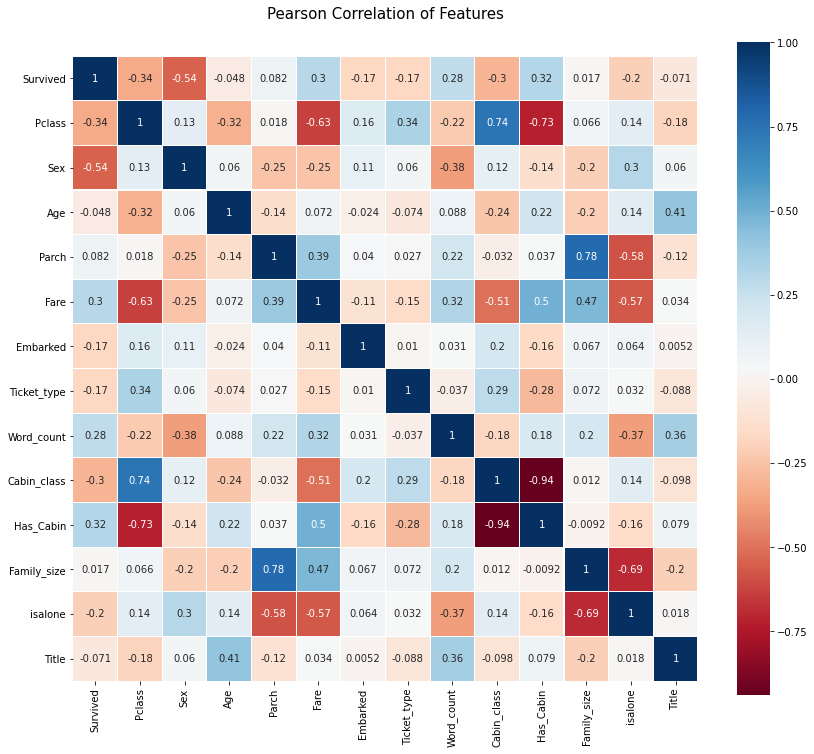

In [69]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [70]:
origin=train.copy()
origin=origin.sample(frac=1, replace=True, random_state=49)
train_raw=origin.loc[:int(origin.shape[0]*0.8)].copy()
valid_raw=origin.loc[int(origin.shape[0]*0.8):].copy()
test['Survived']=0

In [71]:
x_train=train_raw.loc[:, train.columns != 'Survived'].values
y_train=train_raw['Survived'].values

x_valid=valid_raw.loc[:, valid.columns != 'Survived'].values
y_valid=valid_raw['Survived'].values

x_test=test.loc[:, test.columns != 'Survived'].values
y_test=test['Survived']

In [72]:
#has_cabin과 cabin_class가 너무 강하게 연관됨. 개선이 필요
#전처리 끝

분류 신경망 정의하기

In [73]:
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1_1=torch.nn.Linear(13, 512)
        self.fc1_2=torch.nn.Linear(512, 64)
        self.fc1_3=torch.nn.Linear(64, 10)

        self.fc2_1=torch.nn.Linear(13, 64)
        self.fc2_2=torch.nn.Linear(64, 512)
        self.fc2_3=torch.nn.Linear(512, 10)

        self.fc3_1=torch.nn.Linear(13, 128)
        self.fc3_2=torch.nn.Linear(128, 128)
        self.fc3_3=torch.nn.Linear(128, 10)

        self.fc_full_1=torch.nn.Linear(30, 64)
        self.fc_full_2=torch.nn.Linear(64, 128)
        self.fc_full_3=torch.nn.Linear(128, 2)

    def forward(self, x):
        x1=self.fc1_1(x)
        x1=F.relu(x1)
        x1=self.fc1_2(x1)
        x1=F.relu(x1)
        x1=self.fc1_3(x1)
        x1=F.relu(x1)

        x2=self.fc2_1(x)
        x2=F.relu(x2)
        x2=self.fc2_2(x2)
        x2=F.relu(x2)
        x2=self.fc2_3(x2)
        x2=F.relu(x2)

        x3=self.fc3_1(x)
        x3=F.relu(x3)
        x3=self.fc3_2(x3)
        x3=F.relu(x3)
        x3=self.fc3_3(x3)
        x3=F.relu(x3)


        x=torch.cat((x1, x2, x3), dim=1)
        x=self.fc_full_1(x)
        x=F.relu(x)
        x=self.fc_full_2(x)
        x=F.relu(x)
        x=self.fc_full_3(x)

        return x

model=Net()

필요한 로스 함수와 옵티마이저 설정

In [74]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [75]:
#accuracy 계산 함수
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [76]:
from sklearn.utils import shuffle
from torch.autograd import Variable

for epoch in range(100):
    
    model.train()
    x_var = Variable(torch.FloatTensor(x_train))
    y_var = Variable(torch.LongTensor(y_train))

    optimizer.zero_grad()
    # Forward + Backward + Optimize
    
    train_pred = model(x_var)
    loss =criterion(train_pred, y_var)
    loss.backward()
    optimizer.step()

    

    train_acc=calc_accuracy(train_pred, y_var)
    loss=loss.data.numpy()

    if epoch%10==0: 
        print('Epoch ', epoch)
        print(loss, train_acc)

        valid_pred=model(Variable(torch.FloatTensor(x_valid)))
        valid_loss=criterion(valid_pred, Variable(torch.LongTensor(y_valid)))
        valid_acc=calc_accuracy(valid_pred, Variable(torch.LongTensor(y_valid)))

        print('valid:  ', valid_loss.data.numpy(), valid_acc)

Epoch  0
0.71028477 0.3815789473684211
valid:   36.867718 0.6363636363636364
Epoch  10
0.8675405 0.618421052631579
valid:   0.6800005 0.6363636363636364
Epoch  20
0.6619985 0.618421052631579
valid:   0.6549511 0.6363636363636364
Epoch  30
0.6330927 0.6960526315789474
valid:   0.6322137 0.6590909090909091
Epoch  40
0.6094473 0.7052631578947368
valid:   0.6207866 0.6893939393939394
Epoch  50
0.6015354 0.7105263157894737
valid:   0.6084557 0.7045454545454546
Epoch  60
0.5935426 0.7144736842105263
valid:   0.5714114 0.7424242424242424
Epoch  70
0.59845334 0.7171052631578947
valid:   0.6032783 0.7121212121212122
Epoch  80
0.5799619 0.7263157894736842
valid:   0.55441964 0.7575757575757576
Epoch  90
0.5748036 0.7355263157894737
valid:   0.5730395 0.7575757575757576


In [97]:
pytorch_prediction=model(Variable(torch.FloatTensor(x_test)))

In [98]:
pytorch_prediction=np.argmax(pytorch_prediction.detach().numpy(), axis=1)

In [99]:
pytorch_prediction

array([0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

파트2. XGBoost와 앙상블, 부트스트래핑 기법을 활용한 모델

In [77]:
#XGDBOOST with ensemble

In [79]:
import sklearn
import xgboost as xgb

In [80]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
    n_estimators= 2000,
    max_depth= 4,
    min_child_weight= 2,
    #gamma=1,
    gamma=0.9,                        
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread= -1,
    scale_pos_weight=1).fit(x_train, y_train)
    
xgb_predictions = gbm.predict(x_test)

In [81]:
valid_pred_xgb = gbm.predict(x_valid)

sum_correct=0
for a, b in zip(valid_pred_xgb, y_valid):
    if a==b: 
        sum_correct=sum_correct+1

acc=sum_correct/y_valid.shape[0]
print(acc)


0.9090909090909091


In [100]:
xgb_predictions

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

앙상블

In [ ]:
w_1=0.3
w_2=0.4

In [ ]:
df_ensemble = pd.DataFrame()
df_ensemble['id']=test[]
df_ensemble['Survived']=w_1*xgb_predictions + w_2*pytorch_prediction

In [42]:
valid_pred_xgb

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1])

In [ ]:
Submission=xgb_predictions*w_1+xgb_

In [ ]:
StackingSubmission = pd.DataFrame({ 'PassengerId': passengerid,
                            'Survived': xgb_predictions })

In [ ]:
StackingSubmission

,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,0.0
...,...,...
413,1305,0.0
414,1306,0.0
415,1307,0.0
416,1308,0.0
